<h1 style="text-align:center">Who should you sell your insurance to?</h1>

<div style="text-align:center;"><img src="https://images.unsplash.com/photo-1570042707390-2e011141ab78?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1789&q=80" /></div>

**Context:** 
> Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

**About the Data:**
* id:	Unique ID for the customer
* Gender:	Gender of the customer
* Age:	Age of the customer
* Driving_License:
   * 0 : Customer does not have DL 
   * 1 : Customer already has DL
* Region_Code:	Unique code for the region of the customer
* Previously_Insured:
   * 1 : Customer already has Vehicle Insurance 
   * 0 : Customer doesn't have Vehicle Insurance
* Vehicle_Age:	Age of the Vehicle
* Vehicle_Damage:
   * 1 : Customer got his/her vehicle damaged in the past. 
   * 0 : Customer didn't get his/her vehicle damaged in the past.
* Annual_Premium:	The amount customer needs to pay as premium in the year
* PolicySalesChannel:	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
* Vintage:	Number of Days, Customer has been associated with the company
* Response:
   * 1 : Customer is interested 
   * 0 : Customer is not interested

## Imports

In [1]:
# Data Processing
import numpy as np 
import pandas as pd 

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import SGDClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score, f1_score, recall_score, precision_score


from sklearn.model_selection import RandomizedSearchCV

# Exploratory Data Analysis

In [2]:
df_train = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/train.csv')
df_test = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/test.csv')

In [3]:
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
df_test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


The `id` column is unecessary. Let's drop it for `df_train` and `df_test`.

In [5]:
df_train = df_train.drop(['id'], axis=1)
df_test = df_test.drop(['id'], axis=1)

In [6]:
df_train[['Age', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']].describe()

,Age,Annual_Premium,Policy_Sales_Channel,Vintage
count,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,30564.389581,112.034295,154.347397
std,15.511611,17213.155057,54.203995,83.671304
min,20.000000,2630.000000,1.000000,10.000000
25%,25.000000,24405.000000,29.000000,82.000000
50%,36.000000,31669.000000,133.000000,154.000000
75%,49.000000,39400.000000,152.000000,227.000000
max,85.000000,540165.000000,163.000000,299.000000


## Check for NaN values

In [7]:
df_train.isna().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [8]:
df_test.isna().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

We do not have any. That's great!

## Target Value - Response

In [9]:
df_train['Response'].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

Text(0.5, 1.0, 'Response Distribution')

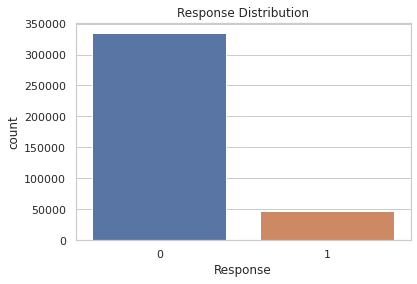

In [10]:
b = sns.countplot(x='Response', data=df_train)
b.set_title("Response Distribution")

We can see that we have a lot more customers that are not interested. This should be taken into account when dividing the data into train and test sets for the modeling.

## Gender

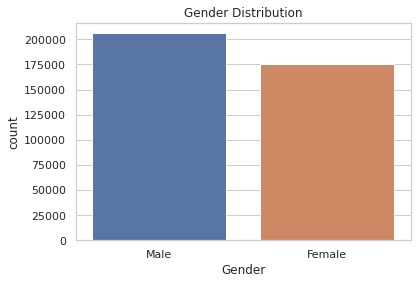

In [11]:
b = sns.countplot(x='Gender', data=df_train)
b.set_title("Gender Distribution");

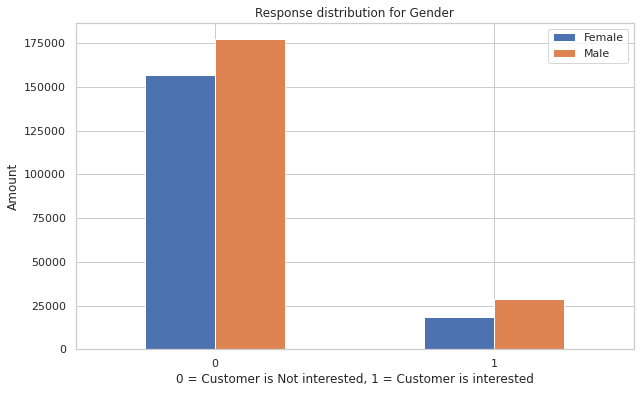

In [12]:
pd.crosstab(df_train['Response'], df_train['Gender']).plot(kind="bar", figsize=(10,6))

plt.title("Response distribution for Gender")
plt.xlabel("0 = Customer is Not interested, 1 = Customer is interested")
plt.ylabel("Amount")
plt.legend(["Female", "Male"])
plt.xticks(rotation=0);

Both genders seem to be pretty similar in their response.

## Age

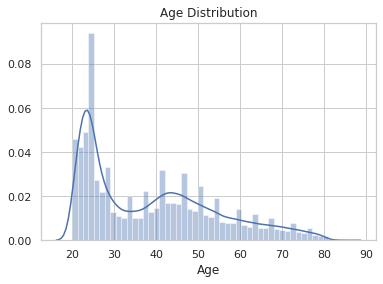

In [13]:
b = sns.distplot(df_train['Age'])
b.set_title("Age Distribution");

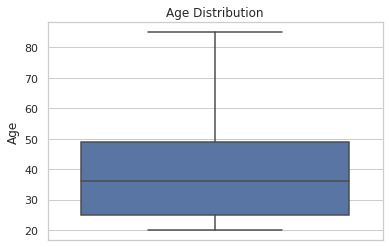

In [14]:
b = sns.boxplot(y = 'Age', data = df_train)
b.set_title("Age Distribution");

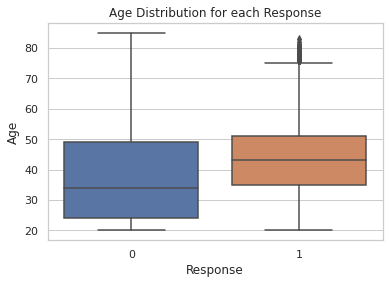

In [15]:
b = sns.boxplot(y='Age', x='Response', data=df_train);
b.set_title("Age Distribution for each Response");

### Driving_License

In [16]:
df_train['Driving_License'].value_counts()

1    380297
0       812
Name: Driving_License, dtype: int64

There are only a small number of people with no driving license. This might mess up our models. Therefore, we should get drop `Driving_License` for now.

In [17]:
df_train = df_train.drop("Driving_License", axis=1)
df_test = df_test.drop("Driving_License", axis=1)

### Region_Code

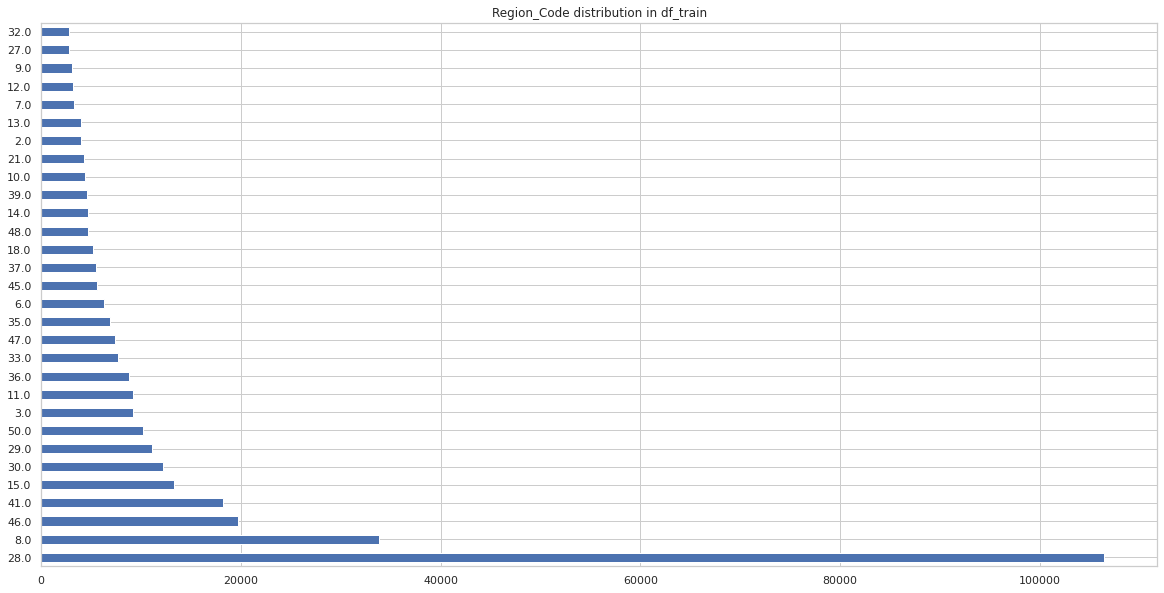

In [18]:
df_train['Region_Code'].value_counts().head(30).plot(kind='barh', figsize=(20,10), title="Region_Code distribution in df_train");

### Previously_Insured

In [19]:
df_train['Previously_Insured'].value_counts()

0    206481
1    174628
Name: Previously_Insured, dtype: int64

In [20]:
pd.crosstab(df_train['Response'], df_train['Previously_Insured'])

Previously_Insured,0,1
Response,,
0,159929,174470
1,46552,158


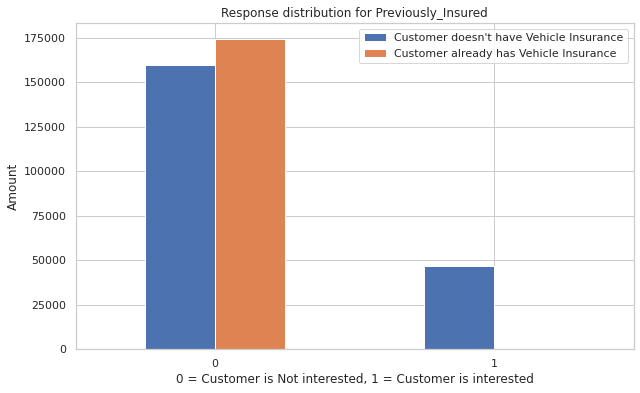

In [21]:
pd.crosstab(df_train['Response'], df_train['Previously_Insured']).plot(kind="bar", figsize=(10,6))

plt.title("Response distribution for Previously_Insured")
plt.xlabel("0 = Customer is Not interested, 1 = Customer is interested")
plt.ylabel("Amount")
plt.legend(["Customer doesn't have Vehicle Insurance", "Customer already has Vehicle Insurance"])
plt.xticks(rotation=0);

We can see that customers that already have a vehicle insurance with only very little exception are not interested.

### Vehicle_Age

In [22]:
df_train['Vehicle_Age'].value_counts()

1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64

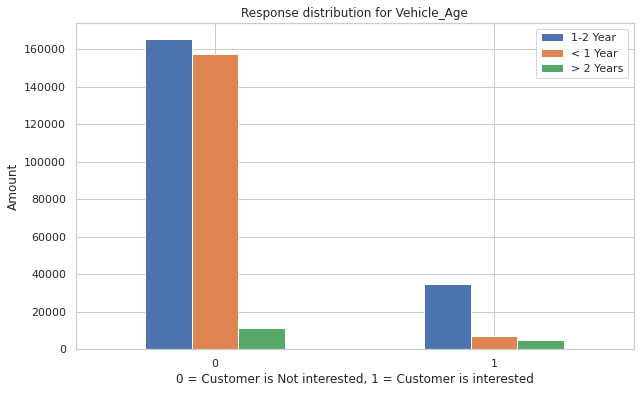

In [23]:
pd.crosstab(df_train['Response'], df_train['Vehicle_Age']).plot(kind="bar", figsize=(10,6))

plt.title("Response distribution for Vehicle_Age")
plt.xlabel("0 = Customer is Not interested, 1 = Customer is interested")
plt.ylabel("Amount")
plt.legend(["1-2 Year", "< 1 Year", "> 2 Years"])
plt.xticks(rotation=0);

### Vehicle_Damage

In [24]:
df_train['Vehicle_Damage'].value_counts()

Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64

In [25]:
pd.crosstab(df_train['Response'], df_train['Vehicle_Damage'])

Vehicle_Damage,No,Yes
Response,,
0,187714,146685
1,982,45728


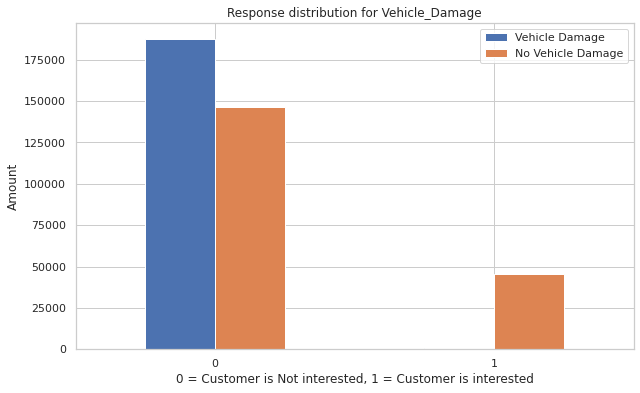

In [26]:
pd.crosstab(df_train['Response'], df_train['Vehicle_Damage']).plot(kind="bar", figsize=(10,6))

plt.title("Response distribution for Vehicle_Damage")
plt.xlabel("0 = Customer is Not interested, 1 = Customer is interested")
plt.ylabel("Amount")
plt.legend(["Vehicle Damage", "No Vehicle Damage"])
plt.xticks(rotation=0);

### Annual_Premium

In [27]:
df_train['Annual_Premium'].describe()

count    381109.000000
mean      30564.389581
std       17213.155057
min        2630.000000
25%       24405.000000
50%       31669.000000
75%       39400.000000
max      540165.000000
Name: Annual_Premium, dtype: float64

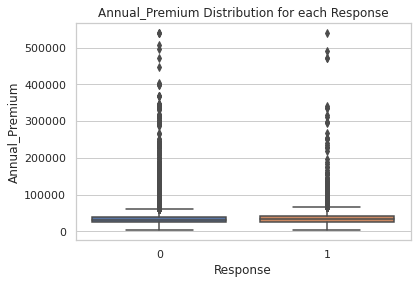

In [28]:
b = sns.boxplot(y='Annual_Premium', x='Response', data=df_train);
b.set_title("Annual_Premium Distribution for each Response");

### Policy_Sales_Channel

In [29]:
df_train['Policy_Sales_Channel'].describe()

count    381109.000000
mean        112.034295
std          54.203995
min           1.000000
25%          29.000000
50%         133.000000
75%         152.000000
max         163.000000
Name: Policy_Sales_Channel, dtype: float64

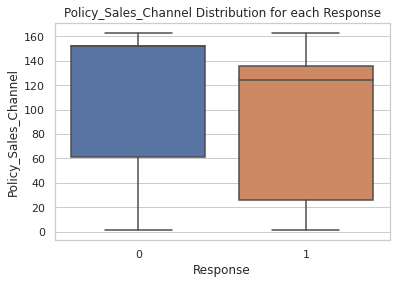

In [30]:
b = sns.boxplot(y='Policy_Sales_Channel', x='Response', data=df_train);
b.set_title("Policy_Sales_Channel Distribution for each Response");

### Vintage

In [31]:
df_train['Vintage'].describe()

count    381109.000000
mean        154.347397
std          83.671304
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64

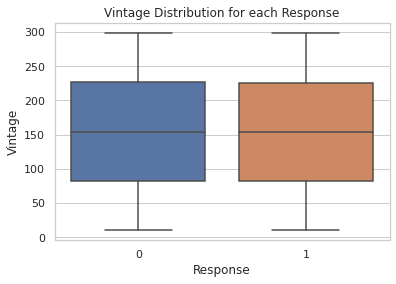

In [32]:
b = sns.boxplot(y='Vintage', x='Response', data=df_train);
b.set_title("Vintage Distribution for each Response");

## Feature Engineering

Let's take a look at our data again.

In [33]:
df_train.head()

,Gender,Age,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,41.0,1,< 1 Year,No,27496.0,152.0,39,0


As a first step, we should get all our data in numeric form.

In [34]:
df_train['Gender'] = pd.Categorical(df_train['Gender'])
df_train['Previously_Insured'] = pd.Categorical(df_train['Previously_Insured'])
df_train['Vehicle_Age'] = pd.Categorical(df_train['Vehicle_Age'])
df_train['Vehicle_Damage'] = pd.Categorical(df_train['Vehicle_Damage'])
df_train['Response'] = pd.Categorical(df_train['Response'])
df_train['Region_Code'] = pd.Categorical(df_train['Region_Code'])

df_train = pd.concat([df_train[['Age', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']],
           pd.get_dummies(df_train[['Gender', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage']])], axis=1)

In [35]:
df_train.head()

,Age,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Female,Gender_Male,Previously_Insured_0,Previously_Insured_1,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,Vehicle_Damage_Yes
0,44,40454.0,26.0,217,1,0,1,1,0,0,0,1,0,1
1,76,33536.0,26.0,183,0,0,1,1,0,1,0,0,1,0
2,47,38294.0,26.0,27,1,0,1,1,0,0,0,1,0,1
3,21,28619.0,152.0,203,0,0,1,0,1,0,1,0,1,0
4,29,27496.0,152.0,39,0,1,0,0,1,0,1,0,1,0


Great! Now our data is in numeric form!

Now let's take a look at the correlation:

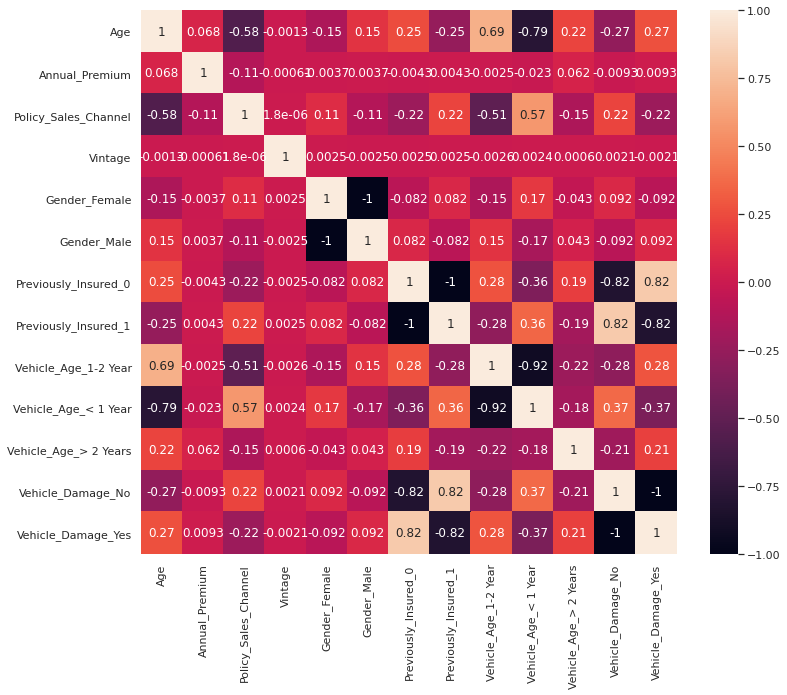

In [36]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df_train.corr()
sns.heatmap(cor, annot=True)
plt.show()

# Modeling

Let's check the scores with all features:

In [37]:
X = df_train.drop(["Response"], axis=1).to_numpy()
y = df_train['Response'].values

Mean roc_auc_score Logistic Regression : 0.8228637770780433
Mean roc_auc_score Random Forest : 0.8227868036074273
Mean roc_auc_score GradientBoostingClassifier : 0.854707413585548


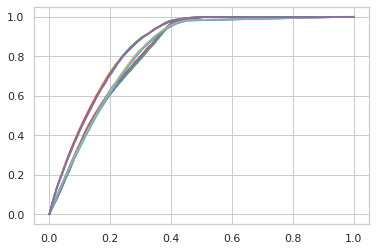

In [38]:
np.random.seed(42)

# Defining a dictionary of models
models = {"Logistic Regression": LogisticRegression(max_iter=10000), 
          "Random Forest": RandomForestClassifier(),
          "GradientBoostingClassifier" : GradientBoostingClassifier()}


# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True)




for name, model in models.items():
    
    # Create list for ROC AUC scores
    roc_auc_score_list = []
    
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        roc_auc_score_list.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        plt.plot(fpr, tpr)

        #print(f"ROC AUC Score for the fold no. {i} on the test set: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}")


    print(f'Mean roc_auc_score {name} : {np.mean(roc_auc_score_list)}')

The `GradientBoostingClassifier()` gives us the best score with an average of `0.854707413585548`.

**Work in Progress**

**If you liked this notebook or found it helpful in any way, feel free to leave an upvote - That will keep me motivated :)**

**If you have any suggestions for improvement, leave a comment :)**